In [26]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
import scipy as sc
import networkx as nx
from sklearn.metrics import silhouette_score, rand_score

np.random.seed(42)
random.seed(42)

# Загрузка данных

In [2]:
df = pd.read_excel('24_MAG_Exam_Practice_17.xls', header=None, usecols=[i for i in range(6)])
df

,0,1,2,3,4,5
0,30,1,15000,4,13000,137000
1,26,0,14600,2,12000,128000
2,33,2,38400,5,37000,378000
3,45,2,8800,13,9000,92000
4,38,2,23400,8,23000,232000
...,...,...,...,...,...,...
65,41,3,37600,10,38000,380000
66,33,1,29900,5,29000,291000
67,54,4,17300,19,20000,190000
68,28,1,26100,3,24000,247000


In [3]:
df.describe()

,0,1,2,3,4,5
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,39.985714,2.071429,20000.000000,9.957143,20014.285714,200014.285714
std,8.074818,1.026058,9999.391286,5.017175,9927.991255,100000.361283
min,20.000000,-1.000000,2600.000000,-2.000000,2000.000000,19000.000000
25%,34.250000,1.250000,11325.000000,6.250000,12000.000000,119750.000000
50%,39.000000,2.000000,20250.000000,9.000000,20000.000000,199500.000000
75%,46.500000,3.000000,26875.000000,14.000000,26750.000000,265750.000000
max,60.000000,5.000000,40300.000000,22.000000,43000.000000,422000.000000


Вывод: Данные очень разнородны, в силу этого может быть полезно сделать стандартизацию.

In [4]:
X = df.to_numpy()
df_norm = pd.DataFrame(X / np.linalg.norm(X, axis=0))
x_st = df_norm.to_numpy()

df_norm.describe()

,0,1,2,3,4,5
count,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000
mean,0.117191,0.107255,0.107059,0.106893,0.107225,0.107059
std,0.023666,0.053127,0.053526,0.053861,0.053188,0.053526
min,0.058616,-0.051778,0.013918,-0.021471,0.010715,0.010170
25%,0.100380,0.064723,0.060622,0.067096,0.064289,0.064097
50%,0.114302,0.103556,0.108397,0.096618,0.107148,0.106784
75%,0.136283,0.155334,0.143860,0.150295,0.143311,0.142244
max,0.175849,0.258890,0.215724,0.236177,0.230369,0.225878


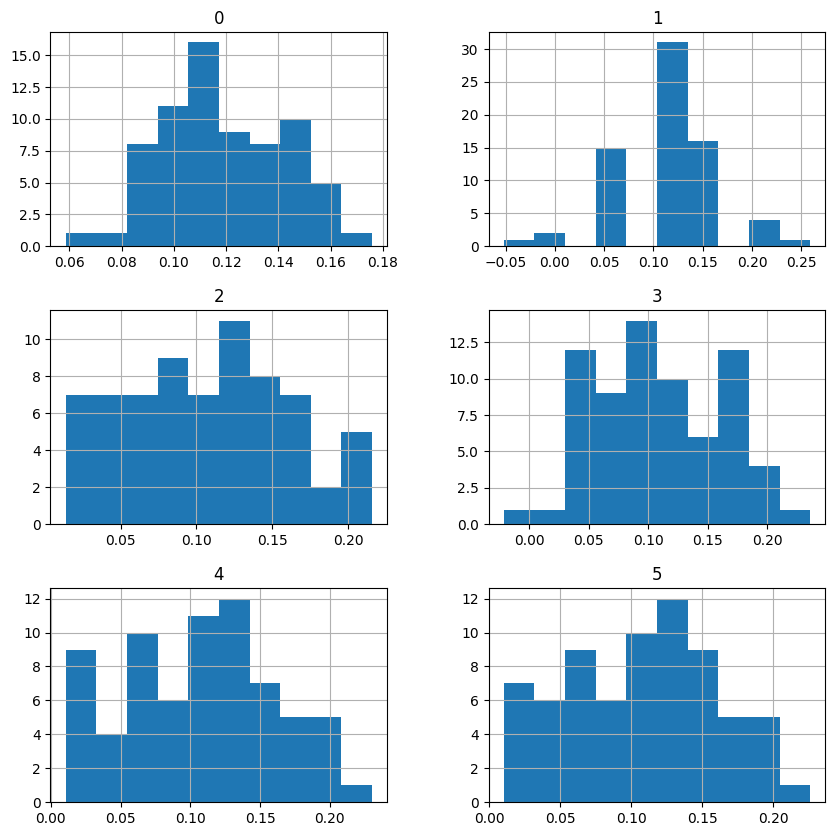

In [5]:
df_norm.hist()
plt.gcf().set_size_inches(10, 10)

Вывод: на гистограмме можно увидеть, что многие признаки имеют (отдаленно) похожее на нормальное распределение. Категориальные признаки, кажется, имеют биномиальное распределение (признак 2)

Text(0.5, 1.0, 'Correlations')

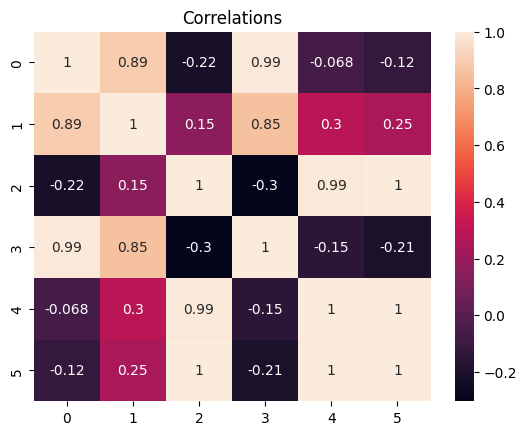

In [6]:
corrs = np.corrcoef(x_st.T)
sns.heatmap(corrs, annot=True)
plt.title("Correlations")

Вывод: матрица корреляций говорит о том, что некоторые признаки очень сильно скоррелированы друг с другом. Это дает намек на возможность успешного снижения размерности

# Снижение размерности. PCA

Некоторые признаки сильно скоррелированы. Это говорит о возможности снижения размерности

In [7]:
pca = PCA(n_components=2).fit(x_st)

evar = np.sum(pca.explained_variance_ratio_)

print(f"Два признака определяют {np.around(evar*100, 2)}% explained variance.")

Два признака определяют 99.12% explained variance.


Погрешность снижения размерности составляет меньше одного процента объясненной дисперсии

In [8]:
x_dim2 = pca.transform(x_st)

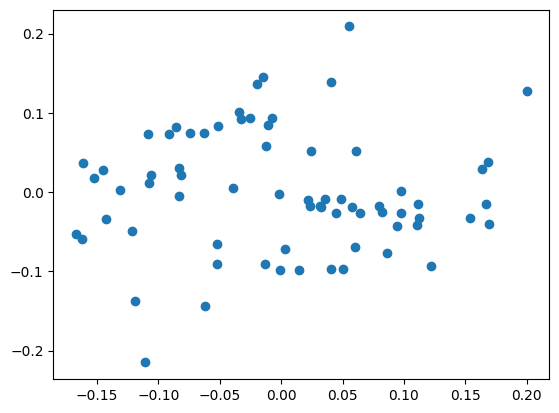

In [9]:
plt.scatter(x_dim2[:, 0], x_dim2[:, 1])

Вывод: в низкой размерности кластерная структура угадывается очень условно. Точки расположены достаточно равномерно

# Кластеризация. MST

<Axes: >

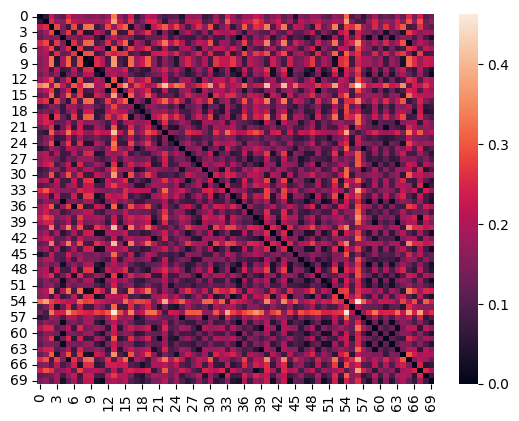

In [10]:
dist_mat = sc.spatial.distance_matrix(x_st, x_st)
sns.heatmap(dist_mat)

Text(0.5, 1.0, 'Гистограмма расстояний')

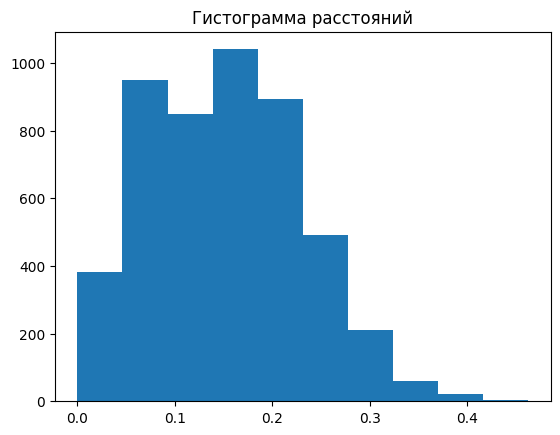

In [38]:
plt.hist(dist_mat.flatten())
plt.title("Гистограмма расстояний")

Большинство объектов равноудалены друг от друга

Для перехода от расстояний к близости используется Гауссово ядро с $\sigma$ = 1

<Axes: >

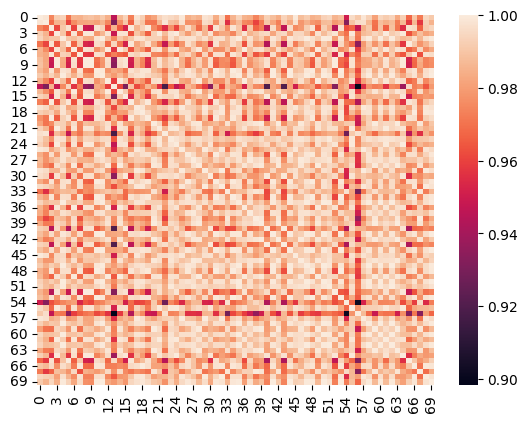

In [43]:
sigma = 1
sim_mat = np.exp(-np.power(dist_mat, 2) / (2*np.power(sigma, 2)))
sns.heatmap(sim_mat)

Вывод: точки достаточно похожи друг на друга. На картинке так же видны несколько точек, которые выделяются из общего правила. Например, 13, 56 и 54

In [13]:
sim_g = nx.from_numpy_array(sim_mat)
mst = nx.maximum_spanning_tree(sim_g)

In [14]:
def find_minimum_edge(graph):
    return min(graph.edges, key=lambda x: graph.get_edge_data(x[0], x[1])["weight"])

def mst_cluster(sim_mst_graph, n_clusters):
    result = sim_mst_graph.copy()
    for _ in range(n_clusters - 1):
        min_edge = find_minimum_edge(result)
        result.remove_edge(*min_edge)

    clustering = np.zeros(len(sim_mst_graph.nodes))

    for idx, c in enumerate(nx.connected_components(result)):
        clustering[list(c)] = idx

    return clustering

def print_clustering(clustering):
    for u in np.unique(clustering):
        print('cluster', int(u) + 1, ':', set(np.where(clustering == u)[0].tolist()))

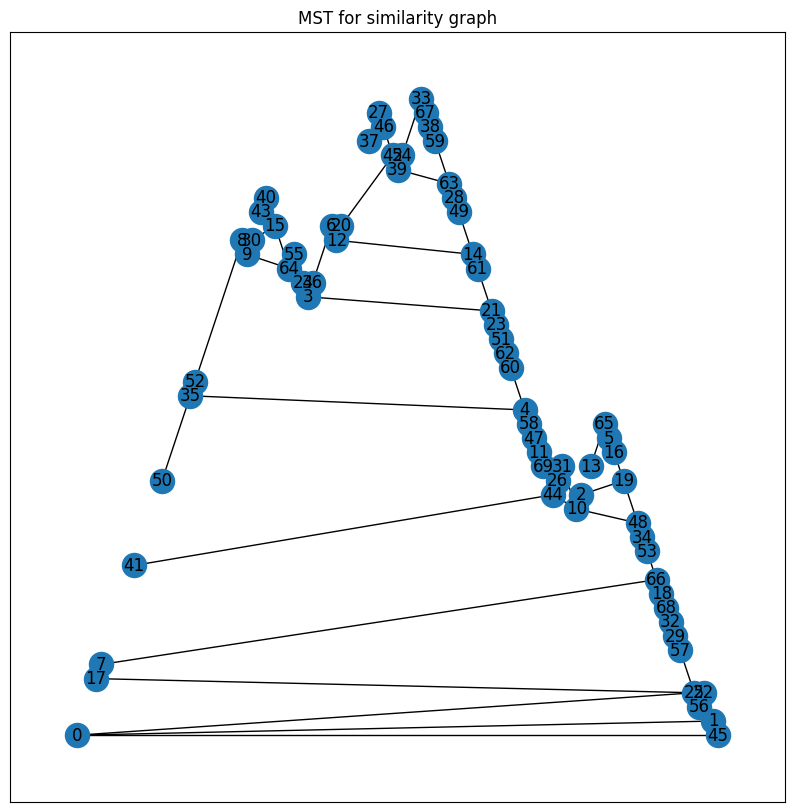

In [44]:
l = nx.planar_layout(mst)

nx.draw_networkx_edges(mst, l)
nx.draw_networkx_nodes(mst, l)
nx.draw_networkx_labels(mst, l)

plt.title("MST for similarity graph")
plt.gcf().set_size_inches(10, 10)

In [19]:
clustering = mst_cluster(mst, 2)

print_clustering(clustering)

cluster 1 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69}
cluster 2 : {13}


Вывод: MST кластеризация отделила 13й объект в отдельный кластер. По матрице близости, это кажется логичным. Т.к. 13й объект сильно отличается от остальных и в MST эта вершина является листом

In [22]:
sil = np.around(silhouette_score(x_st, clustering), 2)

print(f"Silhouette score разбиения на кластеры: {sil}")

Silhouette score разбиения на кластеры: 0.36


Это может говорить о не самом удачном разбиении на кластеры

In [28]:
truth = pd.read_excel('24_MAG_Exam_Practice_17.xls', header=None, usecols=[8,])
true = truth.to_numpy().squeeze()

In [34]:
rand = np.around(rand_score(true, clustering), 2)

print(f"RAND score между истинным и MST разбиениением на кластеры: {rand}")

RAND score между истинным и MST разбиениением на кластеры: 0.5


RAND score = 0.5 является достаточно низким показателем и говорит о плохом разбиении исходных данных на 2 кластера.

# Вывод
1) Данные достаточно хорошо помещаются в пространство размерности 2, однако кластерной структуры в данных визуально не обнаруживается
2) Практически все объекты равноудалены (близки) друг к другу. Лишь несколько объектов выделяются из этого правила
3) MST отделяет один непохожий на все остальные объект в отдельный кластер
4) Silhouette и RAND такого разбиения достаточно низкие. Это говорит либо о неудачности выбора MST для этой задачи, либо о отсутствии кластерной структуры во входных данных. (Кажется, оба фактора сыграли роль)